In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch

# Step 1: Mount Google Drive (if file is stored there)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the path to the .pt file
embedding_path = '/content/drive/MyDrive/Tmdb_posters_custom/poster_embeddings.pt'

# Step 3: Load the embeddings (assumes it's a tensor or dictionary of tensors)
poster_embeddings = torch.load(embedding_path, map_location='cpu')  # use 'cuda' if using GPU

# Step 4: Inspect the content
if isinstance(poster_embeddings, dict):
    for key in poster_embeddings:
        print(f"{key} -> shape: {poster_embeddings[key].shape}")
elif isinstance(poster_embeddings, torch.Tensor):
    print(f"Loaded tensor with shape: {poster_embeddings.shape}")
else:
    print("Loaded object:", type(poster_embeddings))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded tensor with shape: torch.Size([20530, 1280])


In [6]:
# Import necessary libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import requests
from io import BytesIO
from tqdm import tqdm


### POSTERS DOWNLOADED INTO RUNTIME

In [ ]:


# Define paths
csv_path = '/content/drive/MyDrive/Tmdb_posters_custom/undersampled_movie_metadata.csv'
local_poster_dir = '/content/posters'
os.makedirs(local_poster_dir, exist_ok=True)

data = pd.read_csv(csv_path)

# Convert genres from string to list (e.g., "['Action', 'Adventure']" -> ['Action', 'Adventure'])
data['genres'] = data['genres'].apply(eval)

# Create local directory for posters in Colab runtime
local_poster_dir = '/content/posters'
os.makedirs(local_poster_dir, exist_ok=True)

# Function to download posters
def download_poster(poster_path, movie_id):
    url = f"https://image.tmdb.org/t/p/w500{poster_path}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            local_path = os.path.join(local_poster_dir, f"{movie_id}.jpg")
            img.save(local_path)
            return local_path
    except Exception as e:
        print(f"Error downloading {url}: {e}")
    return None

# Download posters with progress bar
tqdm.pandas()
data['local_poster_path'] = data.progress_apply(lambda row: download_poster(row['poster_path'], row['movie_id']), axis=1)

# data['local_poster_path'] = data.progress_apply(lambda row: download_poster(row['poster_path'], row['movie_id']), axis=1)
data = data.dropna(subset=['local_poster_path'])
print(f"After dropping failed downloads, dataset size: {len(data)}")




 82%|████████▏ | 16880/20530 [08:38<34:50,  1.75it/s]  

Error downloading https://image.tmdb.org/t/p/w500/yW97MlBddOeiw17zUSf2iWvOmkr.jpg: HTTPSConnectionPool(host='image.tmdb.org', port=443): Max retries exceeded with url: /t/p/w500/yW97MlBddOeiw17zUSf2iWvOmkr.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7edda31d24d0>, 'Connection to image.tmdb.org timed out. (connect timeout=10)'))


100%|██████████| 20530/20530 [11:00<00:00, 31.10it/s]

After dropping failed downloads, dataset size: 20529


### POSTERS STANDARDIZATION

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


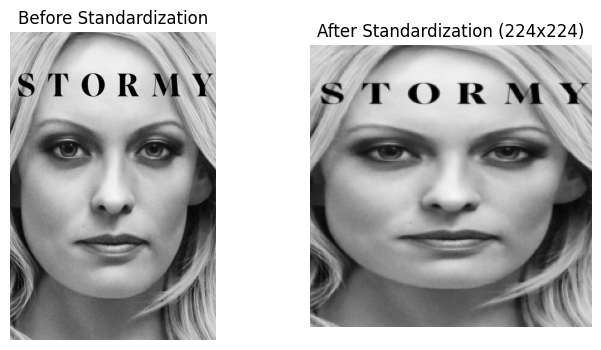

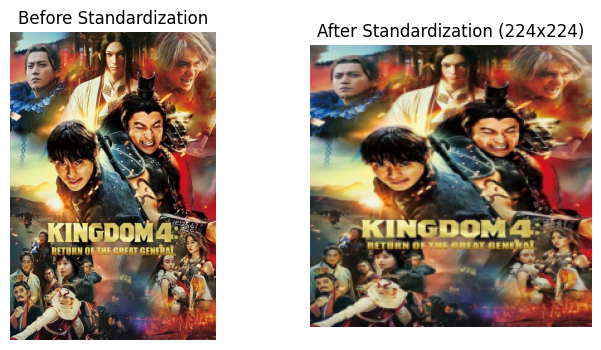

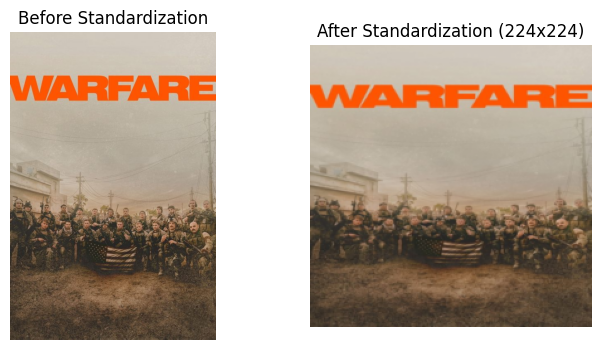

In [2]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#  Set image folder path (change this to your own image directory)
image_folder = "/content/drive/MyDrive/Tmdb_posters_custom/movie_posters"

# Load and display 2–3 sample image paths
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

sample_files = [os.path.join(image_folder, fname)
                for fname in os.listdir(image_folder)[:3]]

#  Define image standardization transform (resize + normalize)
standard_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # standard size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet stds
])

#  Plot before and after standardization
def show_before_after(img_path):
    img = Image.open(img_path).convert('RGB')
    transformed = standard_transform(img)

    # Undo normalization for display
    unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )
    img_for_display = unnormalize(transformed).clamp(0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img)
    axes[0].set_title("Before Standardization")
    axes[0].axis('off')

    axes[1].imshow(img_for_display.permute(1, 2, 0))  # CHW → HWC
    axes[1].set_title("After Standardization (224x224)")
    axes[1].axis('off')
    plt.show()

#  Run for each sample
for path in sample_files:
    show_before_after(path)


### POSTERS AUGMENTAION USING TRANFORMS FUNCTION

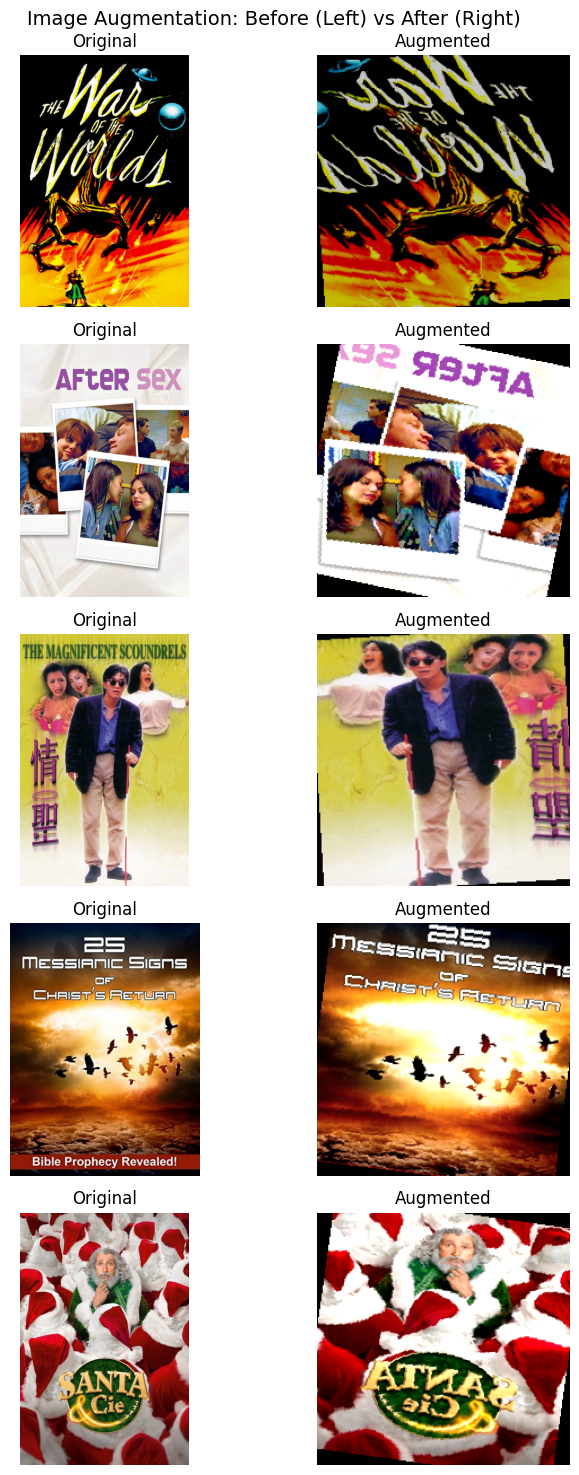

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import torchvision.transforms as transforms
import random

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Tmdb_posters_custom/undersampled_movie_metadata.csv')
df = df.dropna(subset=['poster_path'])  # Ensure valid poster paths

# Adjust this if you already downloaded and saved local posters
poster_dir = '/content/drive/MyDrive/Tmdb_posters_custom/movie_posters'  # Your local image directory
df['local_poster_path'] = df['movie_id'].apply(lambda x: os.path.join(poster_dir, f"{x}.jpg"))

# Sample 5 images
sample_paths = df['local_poster_path'].sample(5, random_state=42).tolist()

# Define augmentation transforms
augment = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor()
])

# Visualization
fig, axs = plt.subplots(5, 2, figsize=(8, 15))
fig.suptitle('Image Augmentation: Before (Left) vs After (Right)', fontsize=14)

for i, path in enumerate(sample_paths):
    original_img = Image.open(path).convert('RGB')
    augmented_img = augment(original_img)

    axs[i, 0].imshow(original_img)
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(transforms.ToPILImage()(augmented_img))
    axs[i, 1].set_title('Augmented')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


## CHECKING NULL ENTRIES IN POSTER PATH

In [ ]:
# Assuming local_dir is defined from the previous block
local_dir = '/content/posters'

# Step 1: Load the CSV file and define `data`
csv_path = '/content/drive/MyDrive/Tmdb_posters_custom/undersampled_movie_metadata.csv'
data = pd.read_csv(csv_path)

# Convert genres from string to list
data['genres'] = data['genres'].apply(eval)

# Step 2: Update local_poster_path column based on movie_id
data['local_poster_path'] = data['movie_id'].astype(str).apply(lambda x: os.path.join(local_dir, f"{x}.jpg"))

# Enhanced filtering to remove invalid entries
data = data.dropna(subset=['local_poster_path'])  # Remove rows with NaN in local_poster_path
data = data[data['local_poster_path'].apply(lambda x: isinstance(x, str))]  # Ensure all are strings
data = data[data['local_poster_path'].apply(lambda x: os.path.isfile(x))]  # Ensure files exist

# Debug: Verify the cleaning
print(f"Initial dataset size: {len(data)}")
print("Sample of local_poster_path values:")
print(data['local_poster_path'].head())
print("Checking for NaN values in local_poster_path:")
print(data['local_poster_path'].isna().sum())
print("Data types in local_poster_path:")
print(data['local_poster_path'].apply(type).value_counts())
print(f"Final dataset size after cleaning: {len(data)}")

Initial dataset size: 20530
Sample of local_poster_path values:
0     /content/posters/3.jpg
1     /content/posters/5.jpg
2     /content/posters/6.jpg
3    /content/posters/11.jpg
4    /content/posters/12.jpg
Name: local_poster_path, dtype: object
Checking for NaN values in local_poster_path:
0
Data types in local_poster_path:
local_poster_path
<class 'str'>    20530
Name: count, dtype: int64
Final dataset size after cleaning: 20530


CONVERTING SOURCE GENRE FROM CSV TO TOKENIZED LIST FOR CORRECT LABELLING OF POSTERS

In [7]:
import pandas as pd
# Drop rows where poster download failed

# Assuming local_dir is defined from the previous block
local_dir = '/content/drive/MyDrive/Tmdb_posters_custom/movie_posters'

# Step 1: Load the CSV file and define `data`
csv_path = '/content/drive/MyDrive/Tmdb_posters_custom/undersampled_movie_metadata.csv'
data = pd.read_csv(csv_path)

# Convert genres from string to list
data['genres'] = data['genres'].apply(eval)

# Step 2: Update local_poster_path column based on movie_id
data['local_poster_path'] = data['movie_id'].astype(str).apply(lambda x: os.path.join(local_dir, f"{x}.jpg"))

# Enhanced filtering to remove invalid entries
data = data.dropna(subset=['local_poster_path'])  # Remove rows with NaN in local_poster_path
data = data[data['local_poster_path'].apply(lambda x: isinstance(x, str))]  # Ensure all are strings
data = data[data['local_poster_path'].apply(lambda x: os.path.isfile(x))]  # Ensure files exist

print('local_poster_path')
data = data.dropna(subset=['local_poster_path'])
print(f"After dropping failed downloads, dataset size: {len(data)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# Define valid genres
valid_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']
data['genres'] = data['genres'].apply(lambda x: [g for g in x if g in valid_genres])
print(data['genres'])

local_poster_path
After dropping failed downloads, dataset size: 20530
Using device: cuda
0         [Romance, Comedy, Drama]
1                  [Comedy, Crime]
2        [Thriller, Action, Crime]
3                         [Action]
4              [Family, Animation]
                   ...            
20525                      [Music]
20526         [Music, Documentary]
20527                [Documentary]
20528                [Documentary]
20529                [Documentary]
Name: genres, Length: 20530, dtype: object


##STEPS
###1. CLEANING NULL POSTERS

###2. MAPPING SOURCE GENRE WITH ONE HOT ENCODED GENRES FOR MULTILABLEL CLASSIFICATION

###3. MULTILABEL-BINARIZER FOR MULTIPLE-GENRE CLASSIFICATION
###4. SPLITTING TRAIN->VAL->TEST
###5. USING TRANSFORMS FOR AUGMENTATION AND RANDOM ROTATION OF IMAGES
###6. CUSTOM DATASET OF POSTERS THROUGH MOVIEPOSTERDATASET
###7. RESNET IMAGE MODEL ARCHITECTURE I/p-> CONV-BATCHNORM-RELU-MAXPOOL2D ->o/p
###8. DATA LOADERS WITH BATCHSIZE 32, 64, 128 ---> (32 selected) ---> HYPERPARAMETER
### CUDA SELCTED FOR T4-GPU ON COLLAB
###9. LOSS BCEWithLogitLoss for Multilabel and AdamW OPTIMIZER with L2 REGULARIZATION of 0.0001

###11. LR SCHEDULER FOR OPTIMIZATION

In [ ]:
# Drop rows where poster download failed
data = data.dropna(subset=['local_poster_path'])
print(f"After dropping failed downloads, dataset size: {len(data)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# Define valid genres
valid_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']
data['genres'] = data['genres'].apply(lambda x: [g for g in x if g in valid_genres])

# One-hot encode genres for multi-label classification
mlb = MultiLabelBinarizer(classes=valid_genres)
genre_labels = mlb.fit_transform(data['genres'])
genre_df = pd.DataFrame(genre_labels, columns=mlb.classes_)
data = pd.concat([data[['local_poster_path', 'genres', 'movie_id']], genre_df], axis=1)

# Split data into train, validation, and test sets
train_val_df, test_df = train_test_split(data, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

# Data augmentation and standardization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standardize image size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standardize image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class MoviePosterDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.genre_columns = list(mlb.classes_)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['local_poster_path']
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx][self.genre_columns].values.astype('float32')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

# Data loaders
train_dataset = MoviePosterDataset(train_df, transform=train_transform)
val_dataset = MoviePosterDataset(val_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


# Define custom ResNet18 architecture
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks (simplified ResNet18 structure)
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )

        # Adaptive pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Increased dropout to prevent overfitting
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) + x  # Residual connection
        x = self.relu(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model
model = CustomResNet18(num_classes=len(mlb.classes_)).to(device)
print(f"Model moved to {device}")

# Hyperparameters
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1 / (train_df[genre].mean() + 1e-6) for genre in mlb.classes_]).to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Lower LR to stabilize training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (outputs > 0).float()  # Threshold at 0 for logits
        correct_train += (preds == labels).sum().item()
        total_train += labels.numel()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = (outputs > 0).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.numel()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    scheduler.step(val_loss)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

After dropping failed downloads, dataset size: 20530
Using device: cuda
Train samples: 14781, Val samples: 3696, Test samples: 2053
Model moved to cuda
Epoch 1/20, Train Loss: 1.1847, Val Loss: 1.1759, Train Acc: 0.5615, Val Acc: 0.5651
Epoch 2/20, Train Loss: 1.1366, Val Loss: 1.1345, Train Acc: 0.5772, Val Acc: 0.5648
Epoch 3/20, Train Loss: 1.1152, Val Loss: 1.0811, Train Acc: 0.5871, Val Acc: 0.6098
Epoch 4/20, Train Loss: 1.0993, Val Loss: 1.0709, Train Acc: 0.5974, Val Acc: 0.6134
Epoch 5/20, Train Loss: 1.0847, Val Loss: 1.0641, Train Acc: 0.6052, Val Acc: 0.6427
Epoch 6/20, Train Loss: 1.0726, Val Loss: 1.0581, Train Acc: 0.6150, Val Acc: 0.6324
Epoch 7/20, Train Loss: 1.0614, Val Loss: 1.0484, Train Acc: 0.6243, Val Acc: 0.6322
Epoch 8/20, Train Loss: 1.0552, Val Loss: 1.0414, Train Acc: 0.6310, Val Acc: 0.6365
Epoch 9/20, Train Loss: 1.0456, Val Loss: 1.0414, Train Acc: 0.6355, Val Acc: 0.6530
Epoch 10/20, Train Loss: 1.0348, Val Loss: 1.0403, Train Acc: 0.6414, Val Acc: 0.66

<All keys matched successfully>

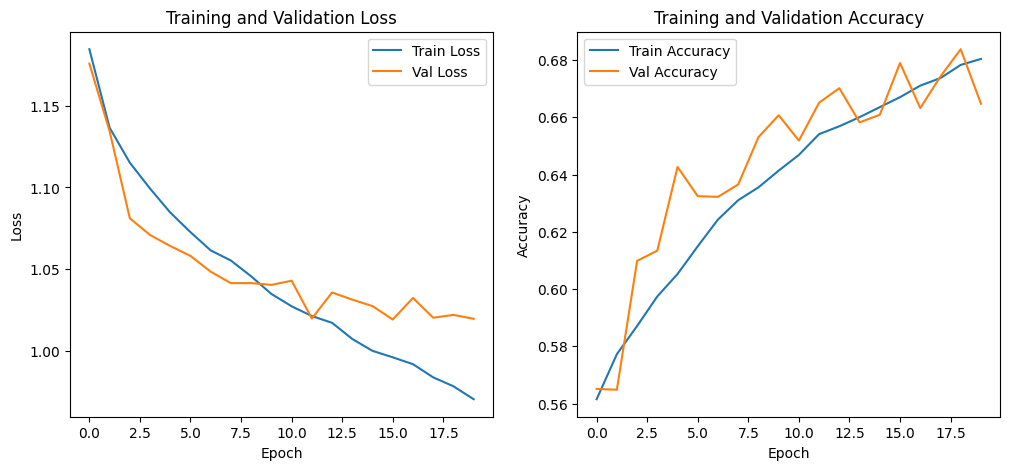

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('resnet18_metrics_plot.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Using threshold 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

val_labels, val_preds = evaluate_model(model, val_loader)

# Classification Report
print("Validation Set Metrics:")
print(classification_report(val_labels, val_preds, target_names=valid_genres, zero_division=0))

Validation Set Metrics:
              precision    recall  f1-score   support

       Drama       0.31      0.84      0.45       896
      Comedy       0.39      0.82      0.52       872
 Documentary       0.48      0.61      0.54       698
     Romance       0.29      0.82      0.43       576
      Action       0.30      0.84      0.44       691
    Thriller       0.37      0.77      0.50       753
      Horror       0.31      0.73      0.44       565
       Crime       0.21      0.76      0.32       467
       Music       0.18      0.65      0.28       453
   Animation       0.41      0.84      0.55       512
    TV Movie       0.24      0.55      0.33       466
      Family       0.38      0.75      0.51       535

   micro avg       0.31      0.76      0.44      7484
   macro avg       0.32      0.75      0.44      7484
weighted avg       0.33      0.76      0.46      7484
 samples avg       0.32      0.75      0.43      7484



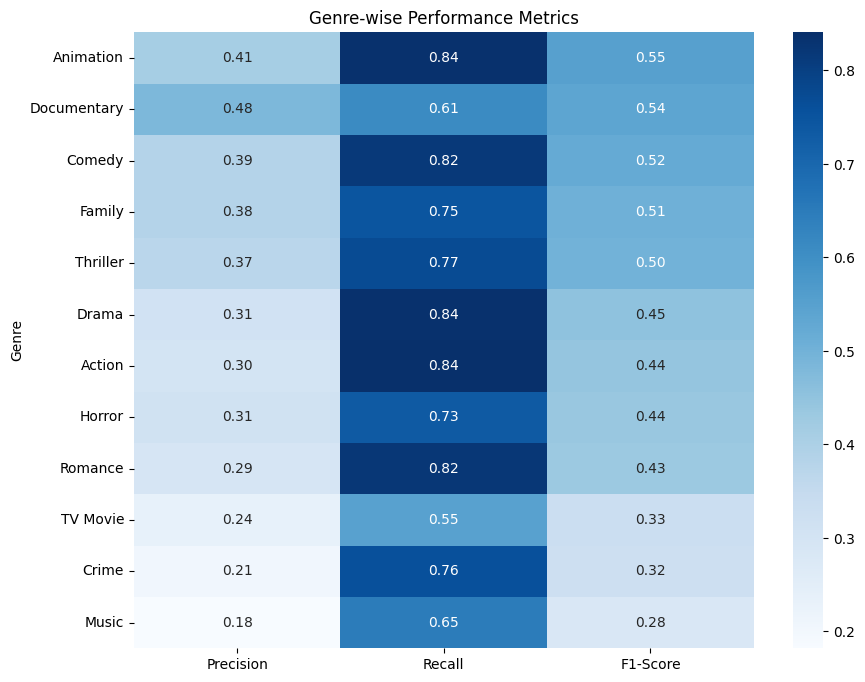

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average=None)
metrics_df = pd.DataFrame({
    'Genre': valid_genres,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Genre')

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_df.sort_values(by='F1-Score', ascending=False),
            annot=True, fmt=".2f", cmap="Blues")
plt.title("Genre-wise Performance Metrics")
plt.show()

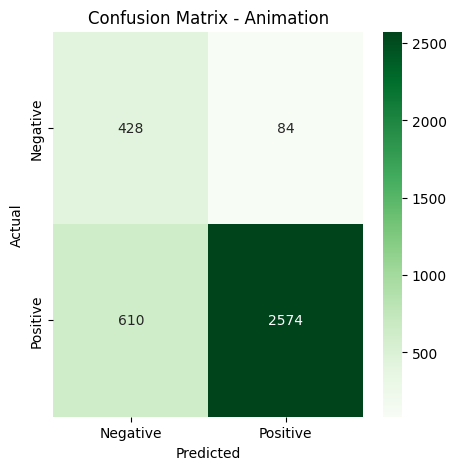

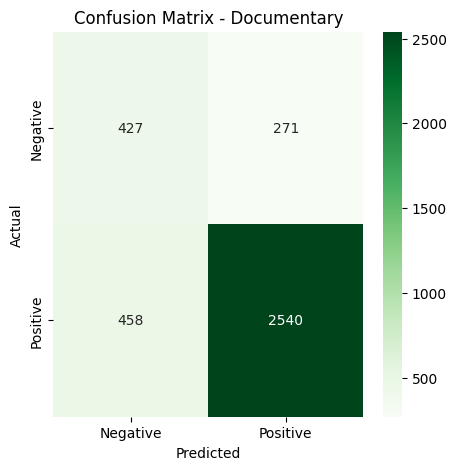

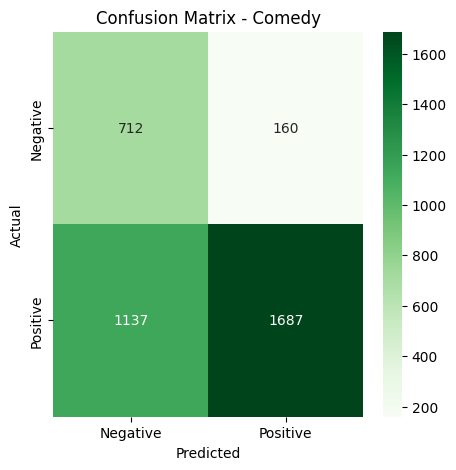

In [ ]:
top_genres = metrics_df.sort_values(by='F1-Score', ascending=False).index[:3]

for genre in top_genres:
    idx = valid_genres.index(genre)
    cm = multilabel_confusion_matrix(val_labels[:, idx], val_preds[:, idx])[0]

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {genre}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

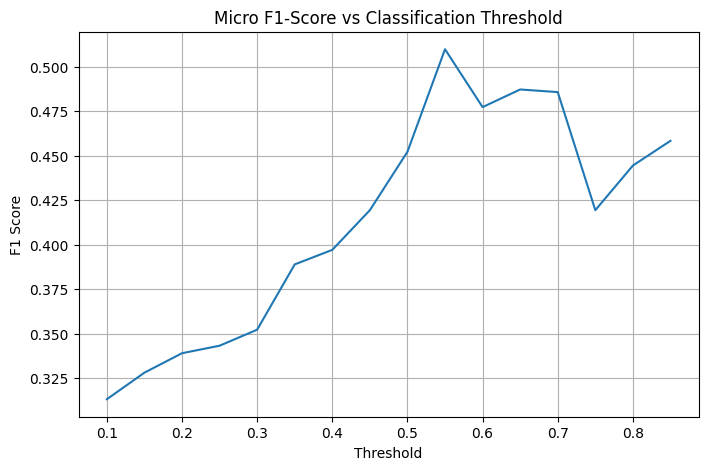

In [ ]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for thresh in thresholds:
    preds = (torch.sigmoid(outputs) > thresh).float()
    f1 = f1_score(labels.cpu(), preds.cpu(), average='micro')
    f1_scores.append(f1)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores)
plt.title("Micro F1-Score vs Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import numpy as np

# Create test DataLoader
test_dataset = MoviePosterDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0).float()  # Threshold at 0 for logits
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
print("Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=valid_genres,
    zero_division=0
))

Classification Report:
              precision    recall  f1-score   support

       Drama       0.32      0.82      0.46       513
      Comedy       0.41      0.84      0.55       506
 Documentary       0.45      0.56      0.50       365
     Romance       0.27      0.82      0.41       297
      Action       0.29      0.81      0.43       393
    Thriller       0.36      0.77      0.49       388
      Horror       0.31      0.71      0.44       318
       Crime       0.20      0.76      0.32       260
       Music       0.22      0.70      0.33       279
   Animation       0.44      0.83      0.57       299
    TV Movie       0.21      0.60      0.31       230
      Family       0.36      0.74      0.49       282

   micro avg       0.31      0.76      0.44      4130
   macro avg       0.32      0.75      0.44      4130
weighted avg       0.33      0.76      0.45      4130
 samples avg       0.32      0.75      0.43      4130



In [ ]:
from sklearn.metrics import f1_score

f1_scores = f1_score(all_labels, all_preds, average=None, zero_division=0)

print("\nGenre-wise F1-Scores:")
for genre, score in zip(valid_genres, f1_scores):
    print(f"{genre}: {score:.3f}")


Genre-wise F1-Scores:
Drama: 0.461
Comedy: 0.552
Documentary: 0.501
Romance: 0.411
Action: 0.430
Thriller: 0.487
Horror: 0.435
Crime: 0.322
Music: 0.332
Animation: 0.573
TV Movie: 0.315
Family: 0.488


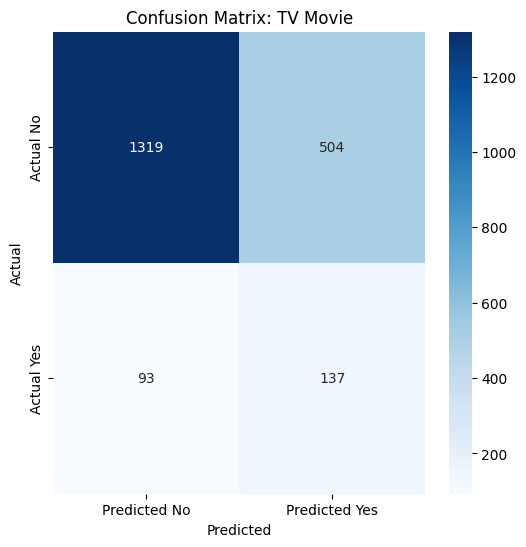

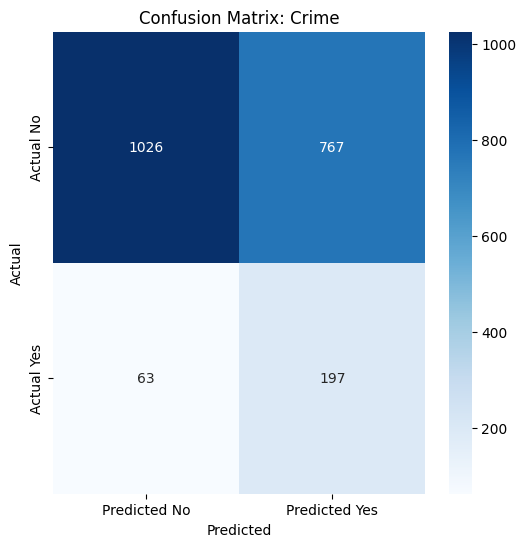

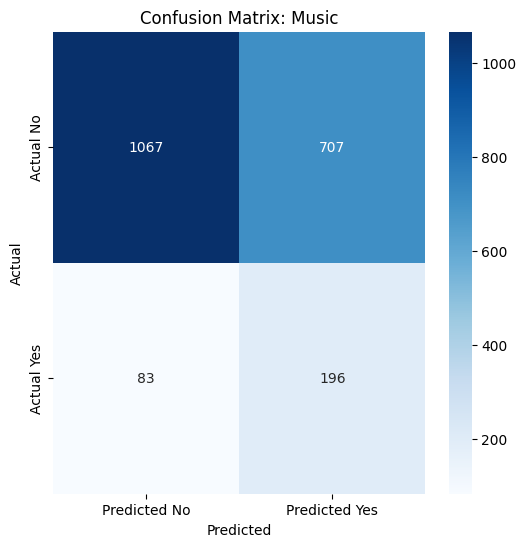

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get confusion matrices for all genres
conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)

# Plot top 3 confused genres (sorted by F1-score)
sorted_indices = np.argsort(f1_scores)
for idx in sorted_indices[:3]:  # Worst-performing genres
    genre = valid_genres[idx]
    cm = conf_matrices[idx]

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Confusion Matrix: {genre}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

# Get predictions and labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Genre-wise confusion matrices
genre_cms = multilabel_confusion_matrix(all_labels, all_preds)

# Top combinations (adjusted for typos)
top_combinations = [
    ('Drama', 'Romance'),
    ('Horror', 'Thriller'),  # Fix "Honor" → "Horror"
    ('Documentary', 'Music'),
    ('Animation', 'Comedy', 'Family'),
    ('Comedy', 'Romance'),
    ('Animation', 'Family'),
    ('Comedy', 'Drama', 'Romance'),
    ('Drama', 'TV Movie'),
    ('Crime', 'Drama', 'Thriller'),  # Fix "Chime" → "Crime"
    ('Action', 'Thriller')
]

# Compute combination confusion matrices
combo_cms = []
for combo in top_combinations:
    # Get indices of genres in the combination
    indices = [valid_genres.index(g) for g in combo]
    # True labels: 1 if all genres in combo are present
    true_combo = np.all(all_labels[:, indices], axis=1)
    # Predicted labels: 1 if all genres in combo are predicted
    pred_combo = np.all(all_preds[:, indices], axis=1)
    # Compute CM
    cm = confusion_matrix(true_combo, pred_combo)
    combo_cms.append(cm)

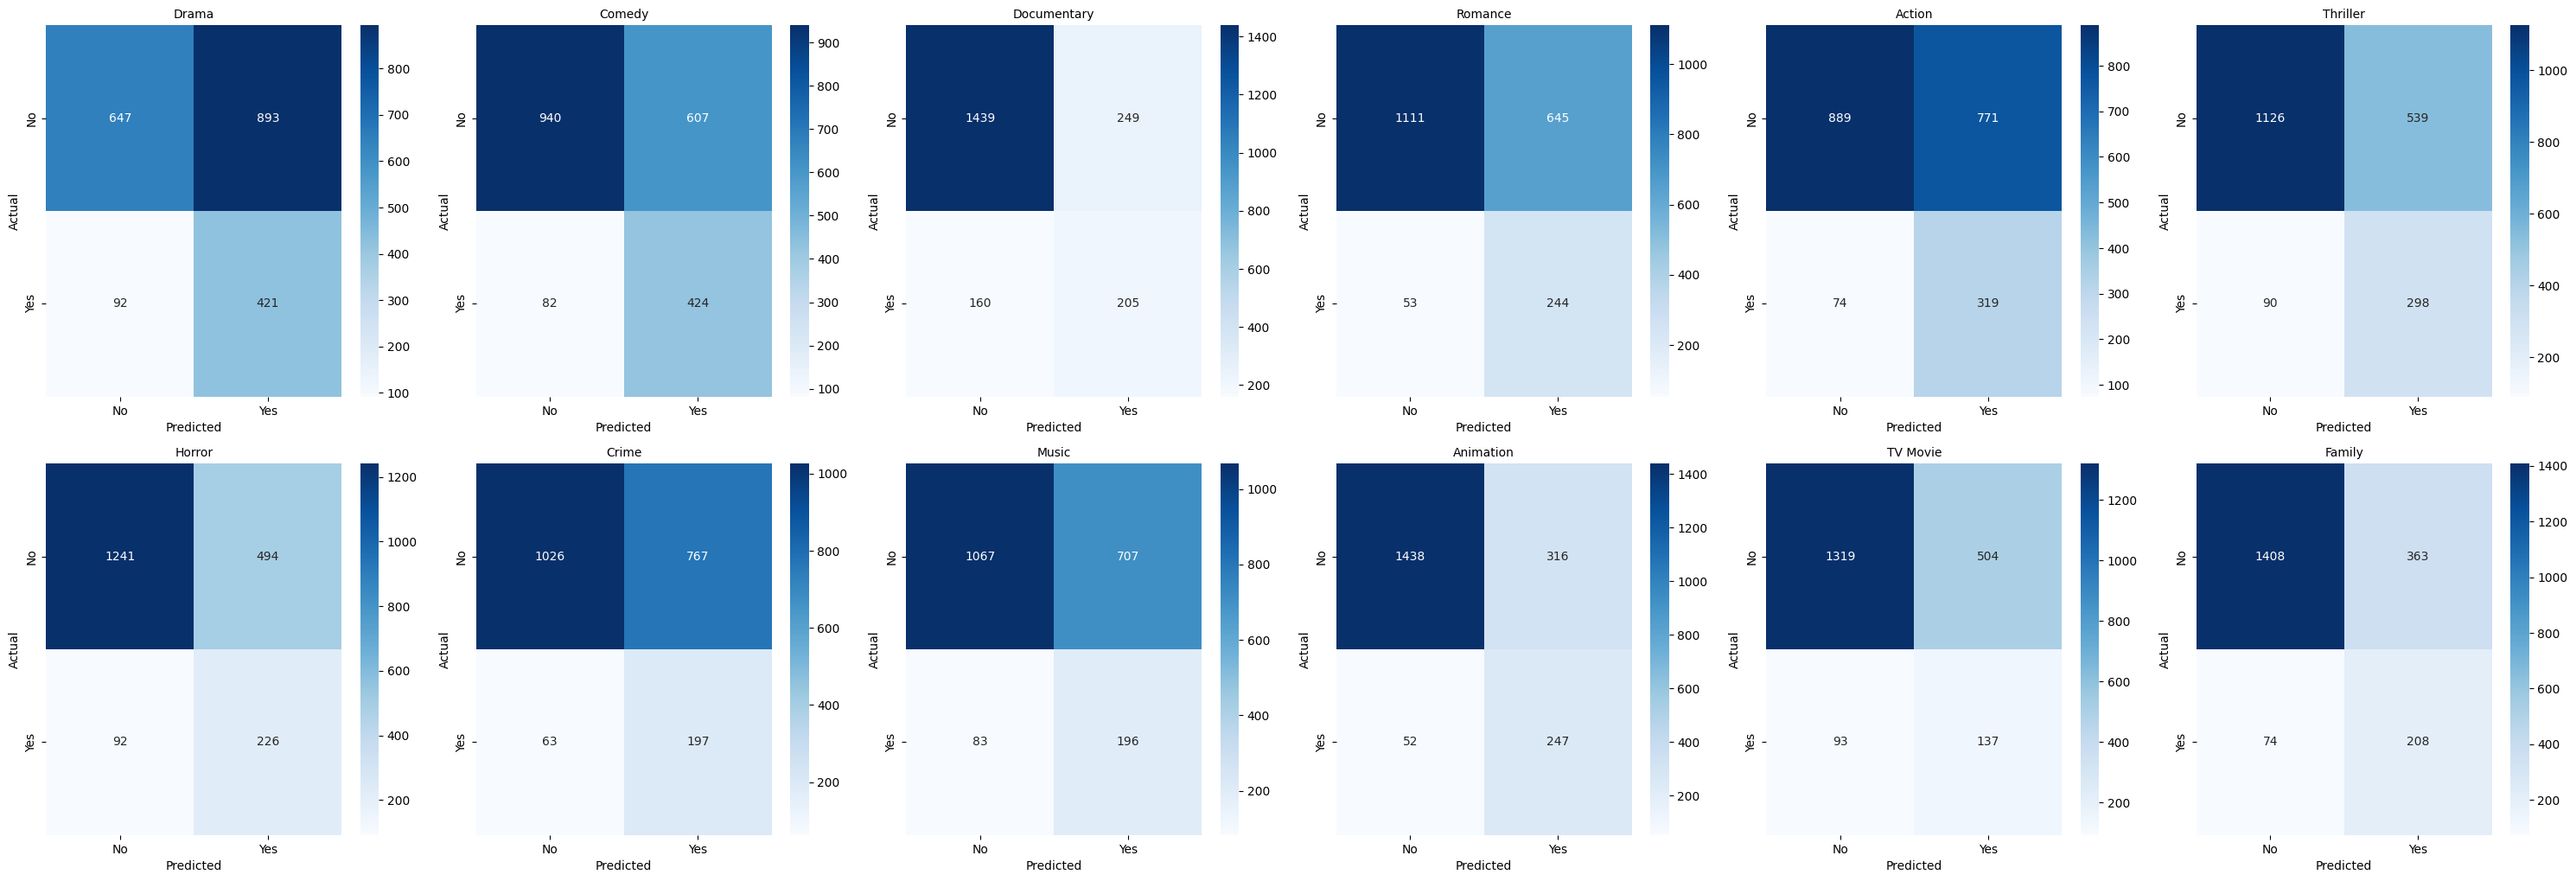

In [ ]:
plt.figure(figsize=(30, 20))

# Plot individual genres (4x3 grid)
for i in range(12):
    plt.subplot(4, 6, i+1)  # 4 rows, 6 columns (first 12 slots)
    sns.heatmap(genre_cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'{valid_genres[i]}', fontsize=10)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')


plt.tight_layout()
plt.show()

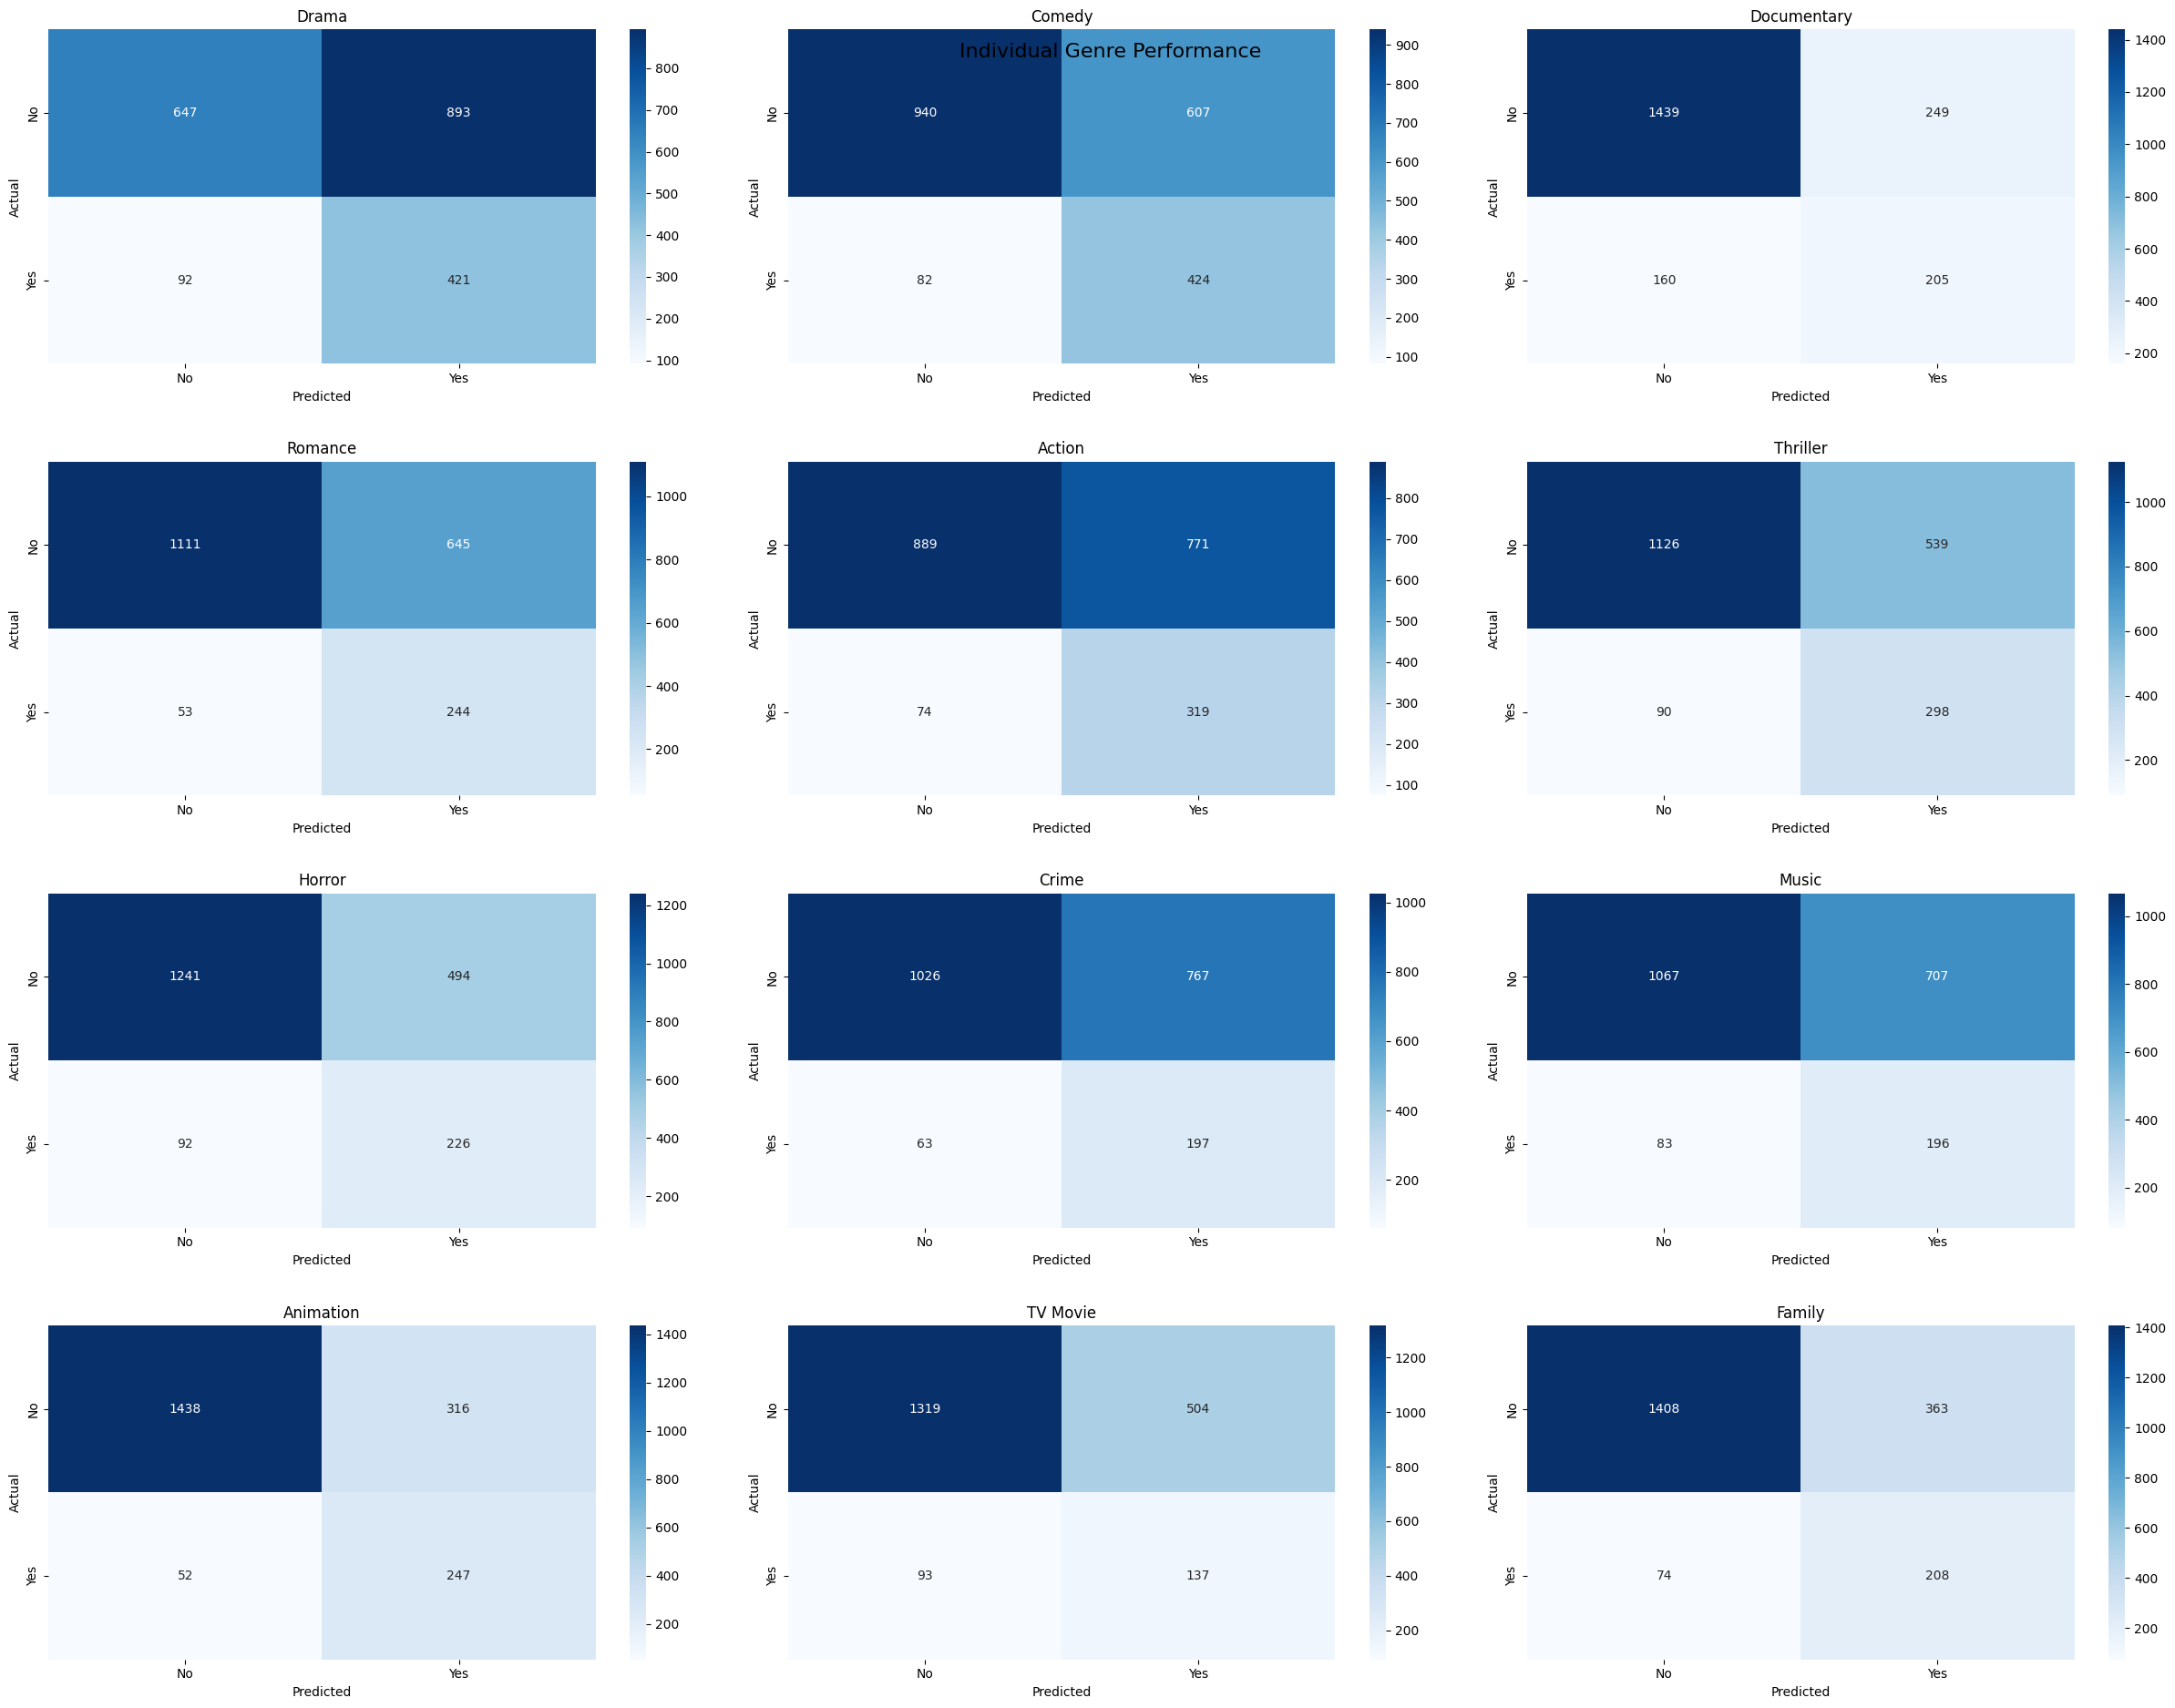

In [ ]:
# Single-genre plot
plt.figure(figsize=(25, 20))
plt.suptitle("Individual Genre Performance", fontsize=16, y=0.93)

for i, genre in enumerate(valid_genres):
    plt.subplot(4, 3, i+1)  # 4 rows x 3 columns
    sns.heatmap(genre_cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'])
    plt.title(f'{genre}', fontsize=12)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout(pad=3.0)
plt.show()

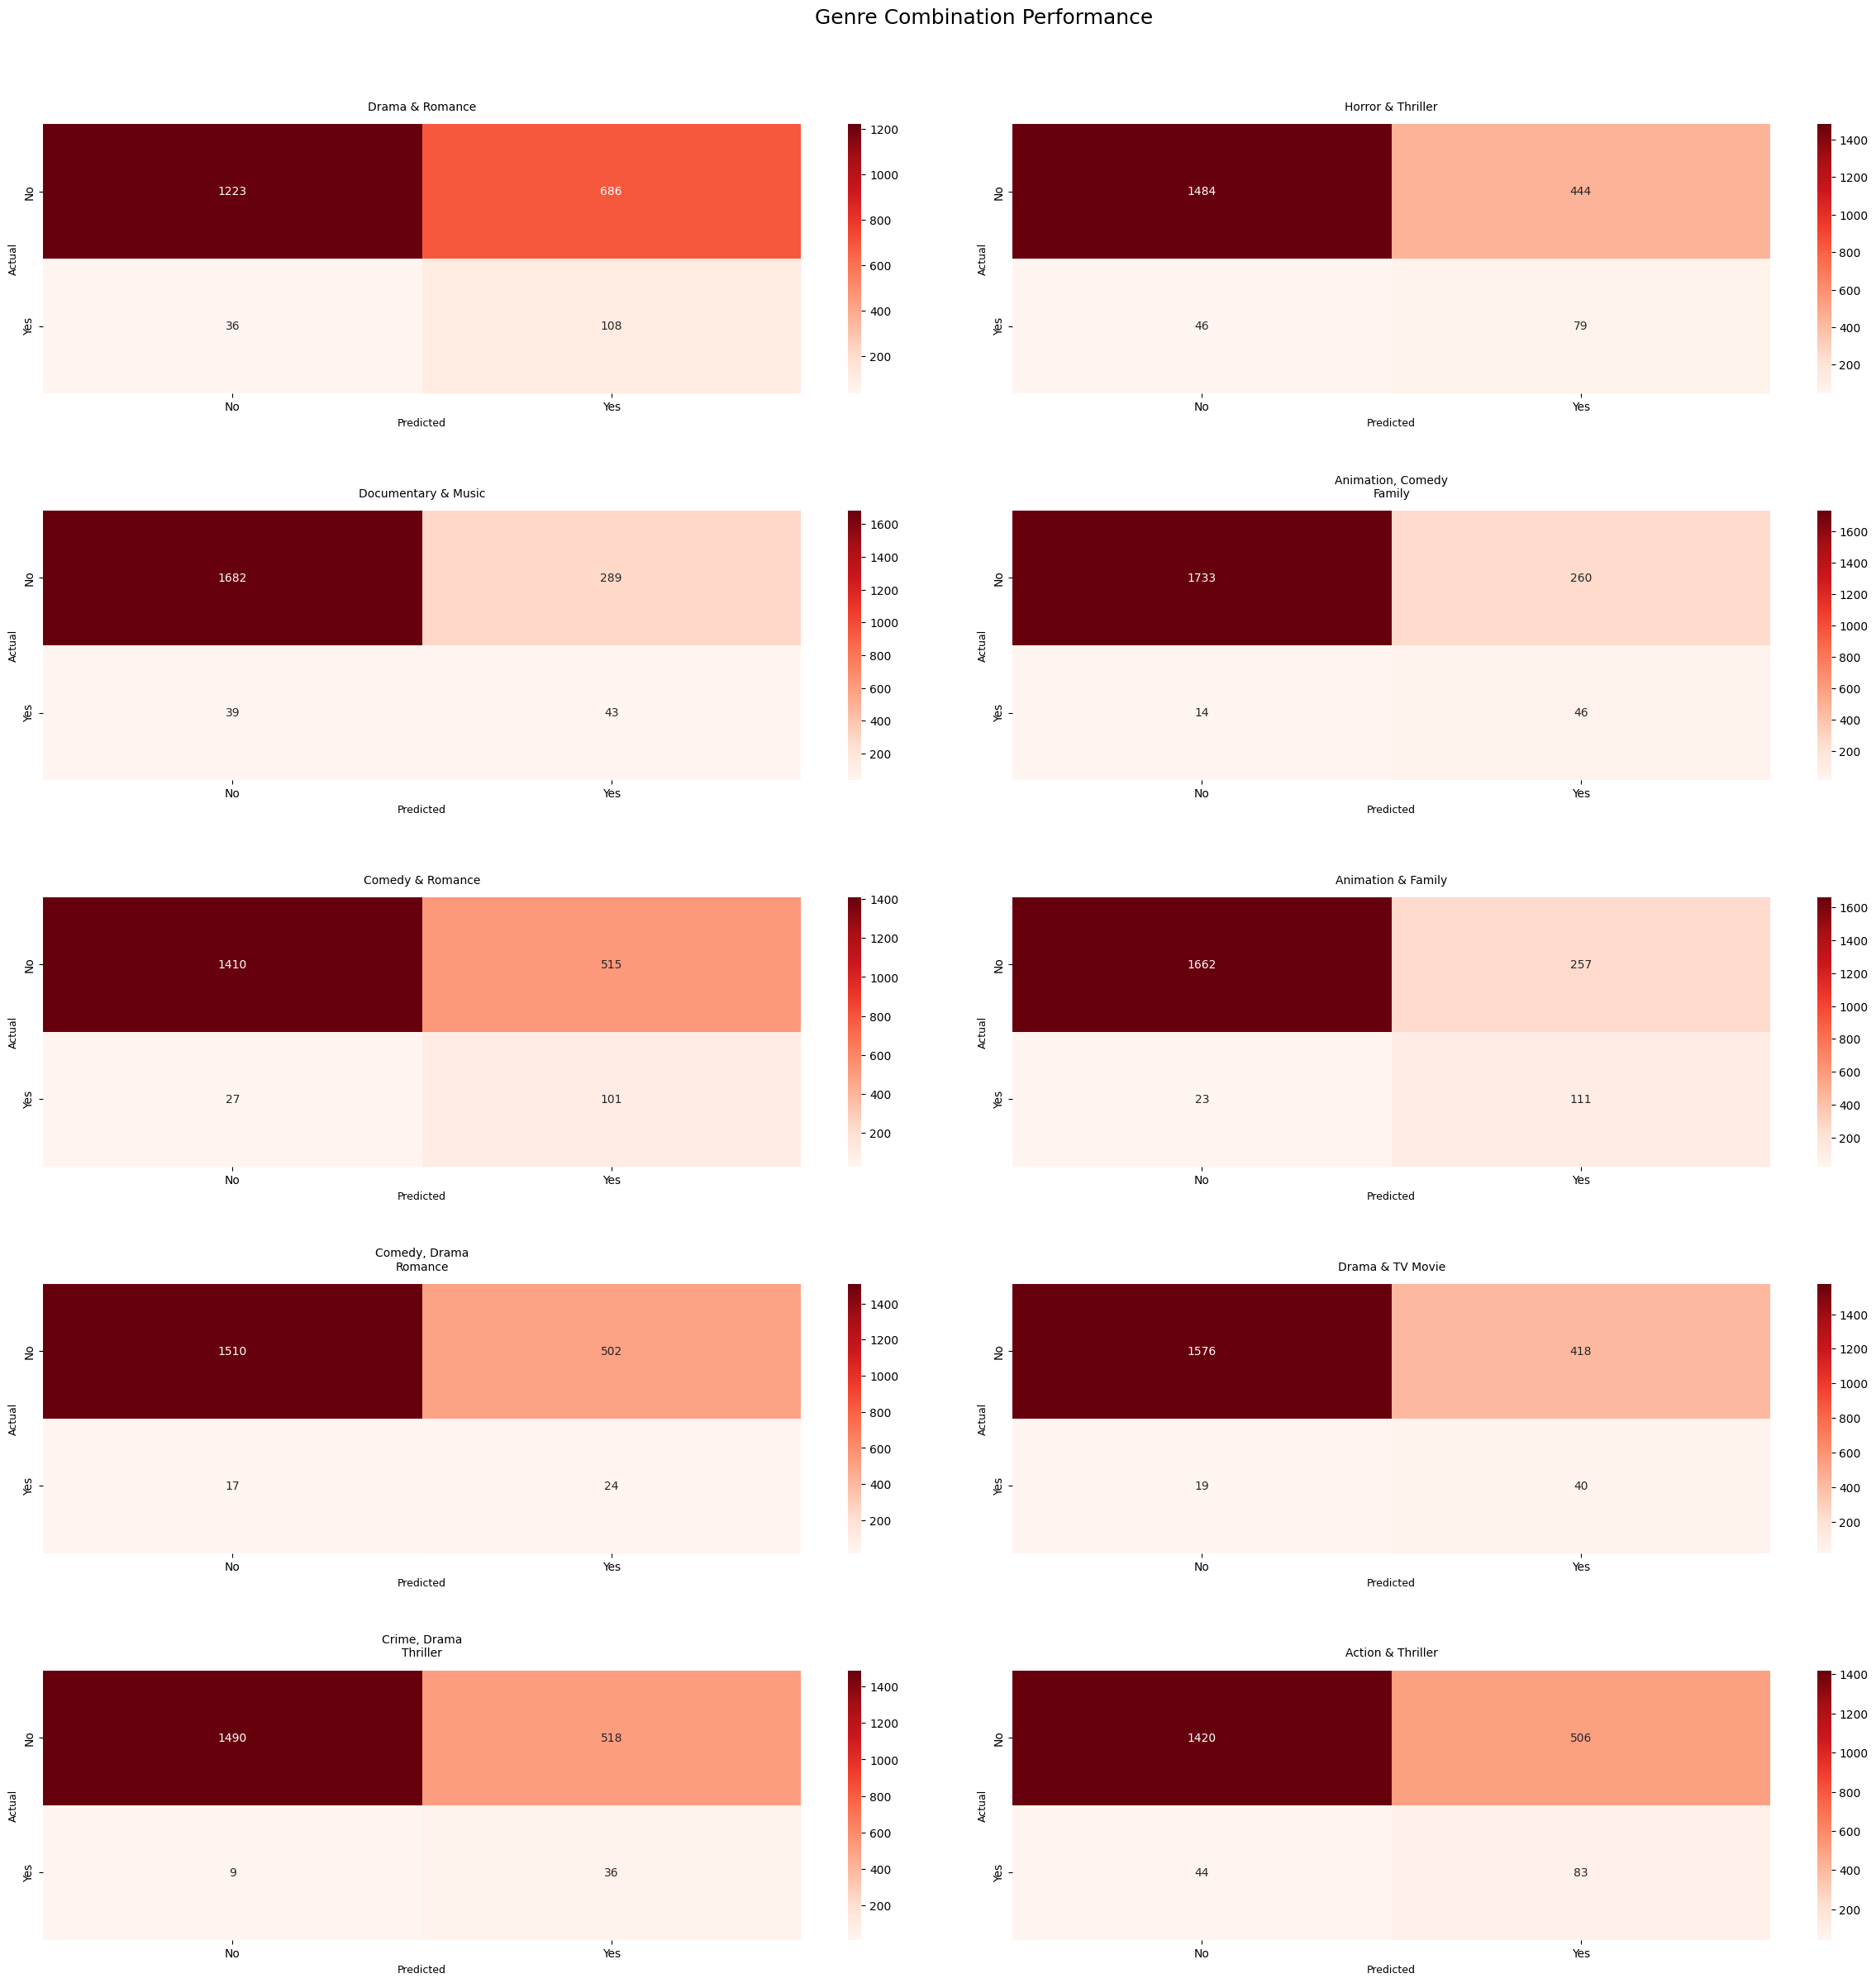

In [ ]:
plt.figure(figsize=(25, 25))  # Increased height for spacing
plt.suptitle("Genre Combination Performance", fontsize=18, y=0.98)  # Higher y-position

for i, combo in enumerate(top_combinations):
    plt.subplot(5, 2, i+1)
    sns.heatmap(combo_cms[i], annot=True, fmt='d', cmap='Reds',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'])

    # Split long titles into 2 lines
    if len(combo) > 2:
        title = '\n'.join([', '.join(combo[:2]), ', '.join(combo[2:])])
    else:
        title = ' & '.join(combo)

    plt.title(title, fontsize=10, pad=12)  # Smaller font + padding
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout(pad=5.0, h_pad=4.0, w_pad=4.0)  # Increased padding
plt.show()

In [ ]:
# Prepare test dataset and loader
test_dataset = MoviePosterDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Function to get predictions
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    return all_preds, all_labels

# Get predictions on test set
test_preds, test_labels = get_predictions(model, test_loader)
binary_preds = (test_preds > 0.5).astype(int)  # Threshold probabilities at 0.5 for binary predictions

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Calculate and print metrics for each genre
print("Per-Genre Evaluation Metrics:")
for i, genre in enumerate(mlb.classes_):
    precision = precision_score(test_labels[:, i], binary_preds[:, i], zero_division=0)
    recall = recall_score(test_labels[:, i], binary_preds[:, i], zero_division=0)
    f1 = f1_score(test_labels[:, i], binary_preds[:, i], zero_division=0)
    roc_auc = roc_auc_score(test_labels[:, i], test_preds[:, i])
    ap = average_precision_score(test_labels[:, i], test_preds[:, i])
    print(f"Genre: {genre}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Average Precision: {ap:.4f}")
    print()

Per-Genre Evaluation Metrics:
Genre: Drama
  Precision: 0.3204
  Recall: 0.8207
  F1-score: 0.4609
  ROC-AUC: 0.7028
  Average Precision: 0.4274

Genre: Comedy
  Precision: 0.4113
  Recall: 0.8379
  F1-score: 0.5517
  ROC-AUC: 0.7986
  Average Precision: 0.5581

Genre: Documentary
  Precision: 0.4515
  Recall: 0.5616
  F1-score: 0.5006
  ROC-AUC: 0.8103
  Average Precision: 0.4939

Genre: Romance
  Precision: 0.2745
  Recall: 0.8215
  F1-score: 0.4115
  ROC-AUC: 0.8113
  Average Precision: 0.4636

Genre: Action
  Precision: 0.2927
  Recall: 0.8117
  F1-score: 0.4302
  ROC-AUC: 0.7695
  Average Precision: 0.4737

Genre: Thriller
  Precision: 0.3560
  Recall: 0.7680
  F1-score: 0.4865
  ROC-AUC: 0.7860
  Average Precision: 0.4591

Genre: Horror
  Precision: 0.3139
  Recall: 0.7107
  F1-score: 0.4355
  ROC-AUC: 0.7871
  Average Precision: 0.4332

Genre: Crime
  Precision: 0.2044
  Recall: 0.7577
  F1-score: 0.3219
  ROC-AUC: 0.7385
  Average Precision: 0.3135

Genre: Music
  Precision: 0.

In [ ]:
from sklearn.metrics import hamming_loss, accuracy_score

# Calculate overall metrics
hamming = hamming_loss(test_labels, binary_preds)
subset_acc = accuracy_score(test_labels, binary_preds)
micro_precision = precision_score(test_labels, binary_preds, average='micro', zero_division=0)
micro_recall = recall_score(test_labels, binary_preds, average='micro', zero_division=0)
micro_f1 = f1_score(test_labels, binary_preds, average='micro', zero_division=0)
micro_roc_auc = roc_auc_score(test_labels, test_preds, average='micro')
micro_ap = average_precision_score(test_labels, test_preds, average='micro')

print("Overall Evaluation Metrics:")
print(f"  Hamming Loss: {hamming:.4f}")
print(f"  Subset Accuracy: {subset_acc:.4f}")
print(f"  Micro-averaged Precision: {micro_precision:.4f}")
print(f"  Micro-averaged Recall: {micro_recall:.4f}")
print(f"  Micro-averaged F1-score: {micro_f1:.4f}")
print(f"  Micro-averaged ROC-AUC: {micro_roc_auc:.4f}")
print(f"  Micro-averaged Average Precision: {micro_ap:.4f}")
print()

Overall Evaluation Metrics:
  Hamming Loss: 0.3192
  Subset Accuracy: 0.0088
  Micro-averaged Precision: 0.3129
  Micro-averaged Recall: 0.7559
  Micro-averaged F1-score: 0.4426
  Micro-averaged ROC-AUC: 0.7877
  Micro-averaged Average Precision: 0.4612



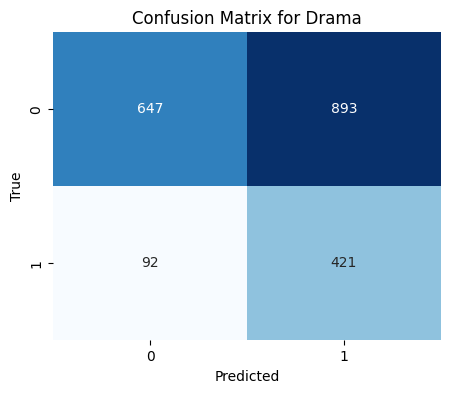

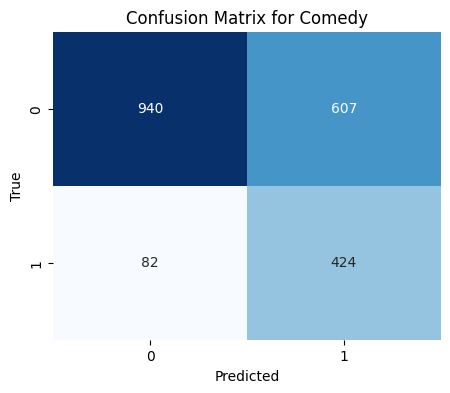

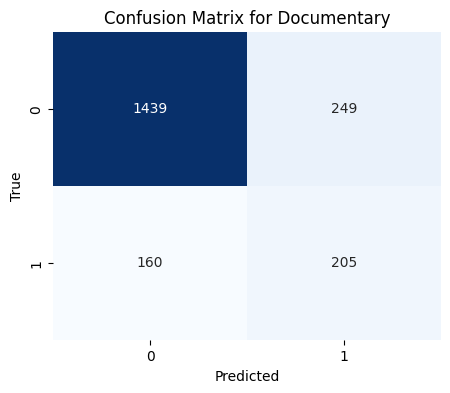

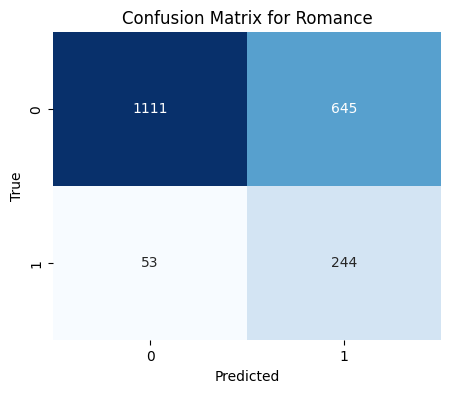

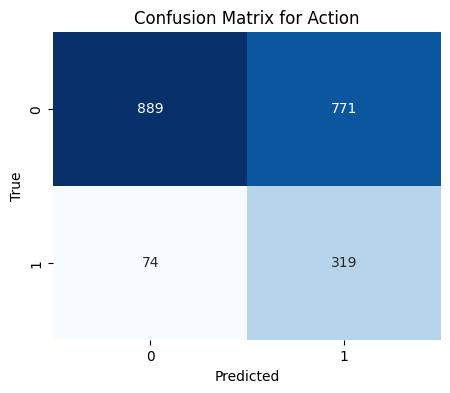

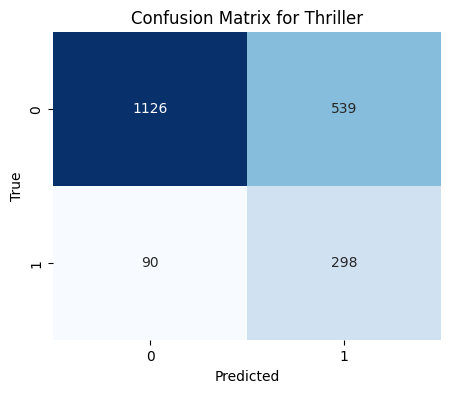

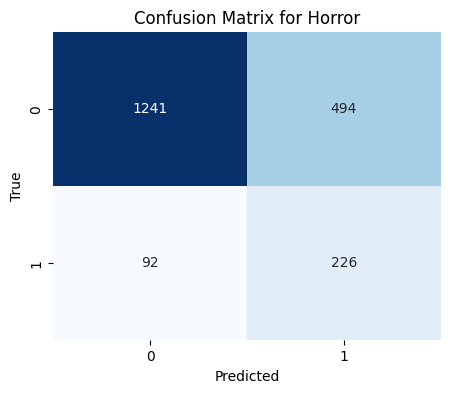

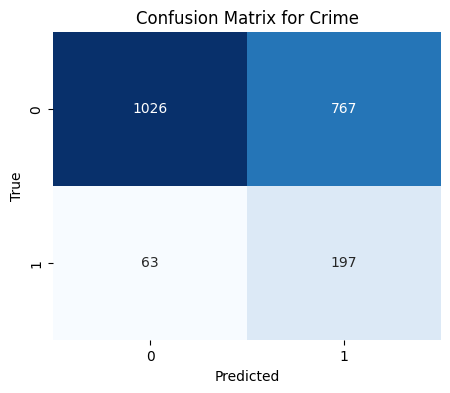

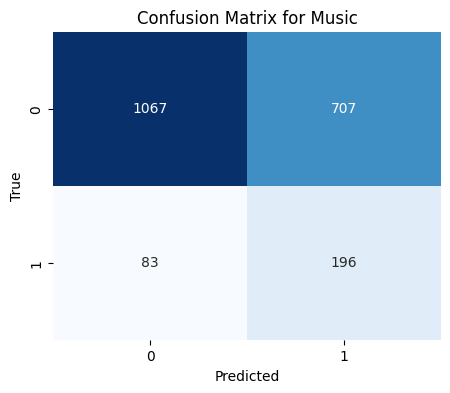

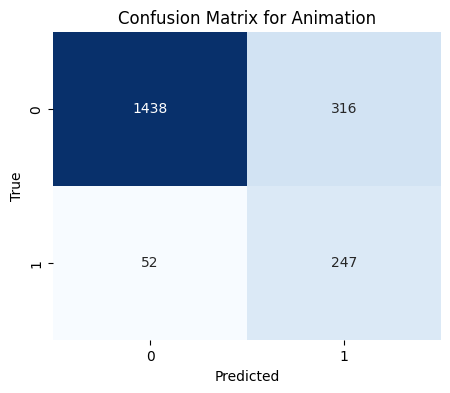

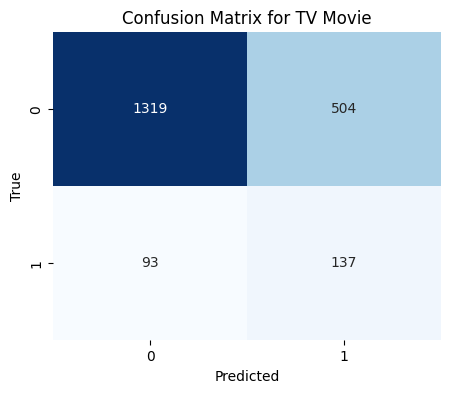

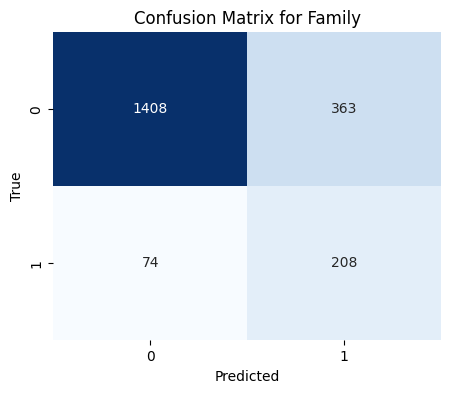

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrices for each genre
for i, genre in enumerate(mlb.classes_):
    cm = confusion_matrix(test_labels[:, i], binary_preds[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {genre}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

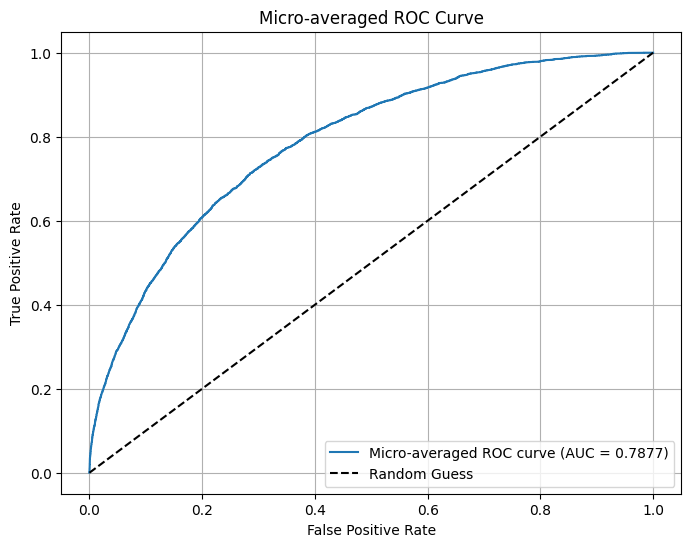

In [ ]:
from sklearn.metrics import roc_curve

# Plot micro-averaged ROC curve
fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds.ravel())
micro_roc_auc = roc_auc_score(test_labels, test_preds, average='micro')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Micro-averaged ROC curve (AUC = {micro_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-averaged ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# PREDICTIONS OF IMAGES AFTER TRAINING VALIDATION OVER SAMPLE IMAGES USING SIGMOID TO CONVERT IT INTO PROBABILITIES

Sample Predictions on Test Set:


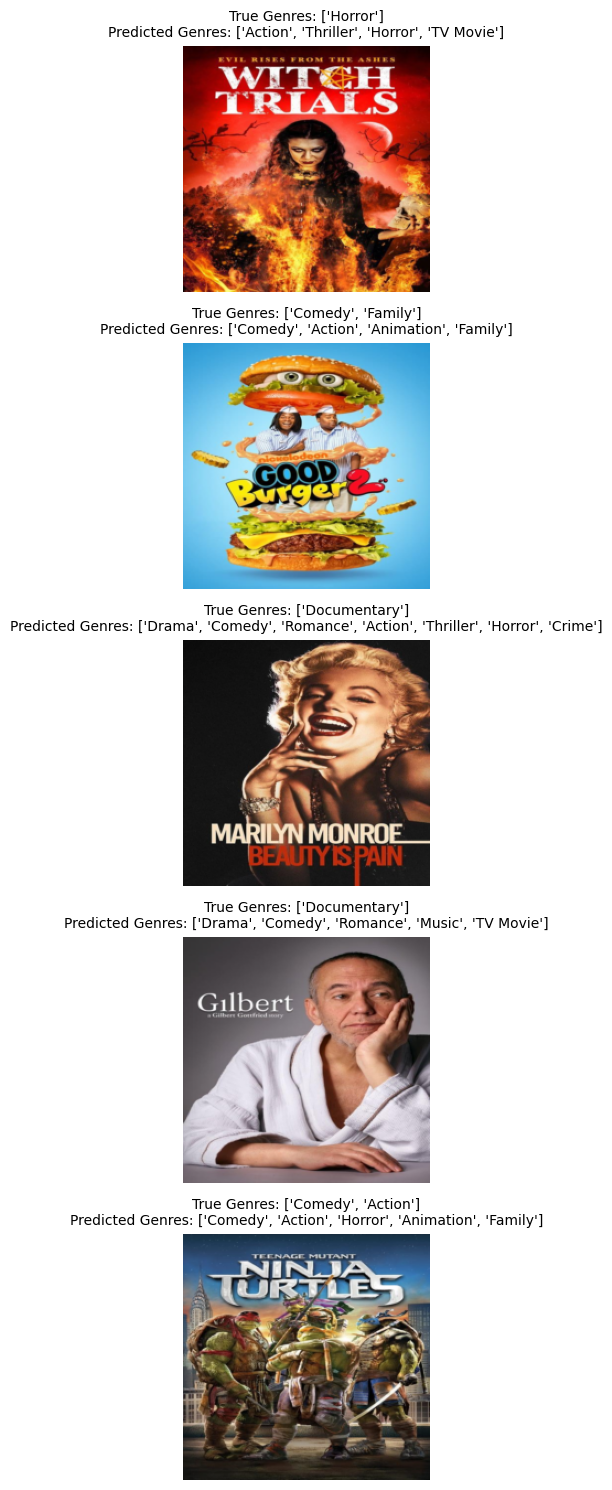

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Define the denormalize function
def denormalize(image_tensor):
    """
    Reverse normalization for visualization.
    Assumes images were normalized with ImageNet mean and std (used in your dataset transforms).
    """
    mean = np.array([0.485, 0.456, 0.406])  # Mean used in your transforms
    std = np.array([0.229, 0.224, 0.225])   # Std used in your transforms
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert from CHW to HWC format
    image = std * image + mean  # Reverse normalization
    return np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1] for display

# Updated show_predictions function to select random images
def show_predictions(model, dataloader, mlb, num_examples=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Display random predictions from the model.

    Args:
        model: Trained PyTorch model
        dataloader: PyTorch DataLoader with test data
        mlb: MultiLabelBinarizer instance for genre labels
        num_examples: Number of examples to display (default: 5)
        device: Device to run the model on (default: CUDA if available, else CPU)
    """
    model.eval()  # Set model to evaluation mode

    # Convert dataloader to a list to allow random sampling
    all_batches = list(dataloader)
    if len(all_batches) == 0:
        print("Error: Dataloader is empty!")
        return

    # Randomly select a batch
    batch_idx = random.randint(0, len(all_batches) - 1)
    images, labels = all_batches[batch_idx]
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()  # Probabilities
        binary_preds = (preds > 0.5).astype(int)      # Binary predictions (threshold at 0.5)

    # Convert to CPU/numpy
    images = images.cpu()
    labels = labels.cpu().numpy()

    # Randomly select indices from the batch to display
    indices = random.sample(range(len(images)), min(num_examples, len(images)))

    # Plot
    plt.figure(figsize=(15, 3 * num_examples))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i + 1)
        image = denormalize(images[idx])  # Denormalize the image for display
        plt.imshow(image)

        # Get genres
        true_genres = [mlb.classes_[i] for i in np.where(labels[idx] == 1)[0]]
        pred_genres = [mlb.classes_[i] for i in np.where(binary_preds[idx] == 1)[0]]

        title = f"True Genres: {true_genres}\nPredicted Genres: {pred_genres}"
        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions on test set
print("Sample Predictions on Test Set:")
# Assuming model, test_loader, and mlb are already defined in your notebook
show_predictions(model, test_loader, mlb, num_examples=5)

Sample Predictions on Test Set (After Training):


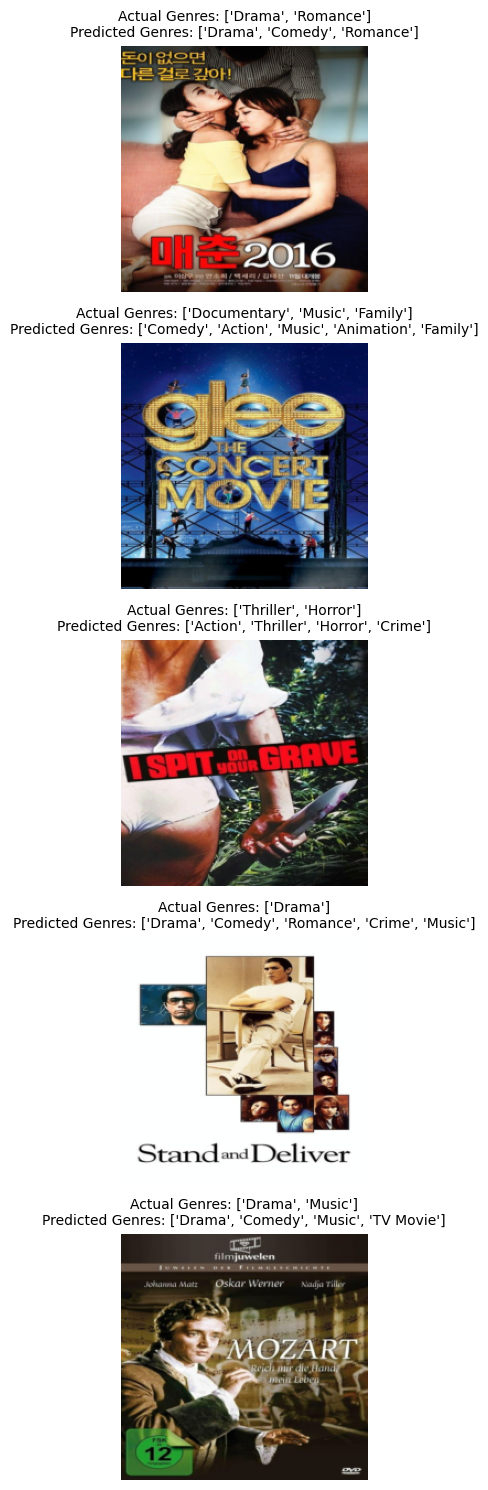

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Define the denormalize function
def denormalize(image_tensor):
    """
    Reverse normalization for visualization.
    Matches the mean and std used in val_transform.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert CHW to HWC
    image = std * image + mean  # Reverse normalization
    return np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1]

# Updated show_predictions function
def show_predictions(model, dataloader, mlb, num_examples=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Display random predictions from the model after training.

    Args:
        model: Trained PyTorch model
        dataloader: PyTorch DataLoader with test data
        mlb: MultiLabelBinarizer instance for genre labels
        num_examples: Number of examples to display (default: 5)
        device: Device to run the model on (default: CUDA if available, else CPU)
    """
    model.eval()  # Set model to evaluation mode

    # Convert dataloader to a list to allow random sampling
    all_batches = list(dataloader)
    if len(all_batches) == 0:
        print("Error: Dataloader is empty!")
        return

    # Randomly select a batch
    batch_idx = random.randint(0, len(all_batches) - 1)
    images, labels = all_batches[batch_idx]
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()  # Probabilities
        binary_preds = (preds > 0.5).astype(int)      # Binary predictions (threshold at 0.5)

    # Convert to CPU/numpy
    images = images.cpu()
    labels = labels.cpu().numpy()

    # Randomly select indices from the batch to display
    indices = random.sample(range(len(images)), min(num_examples, len(images)))

    # Plot
    plt.figure(figsize=(15, 3 * num_examples))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i + 1)
        image = denormalize(images[idx])  # Denormalize the image for display
        plt.imshow(image)

        # Get genres
        true_genres = [mlb.classes_[j] for j in np.where(labels[idx] == 1)[0]]
        pred_genres = [mlb.classes_[j] for j in np.where(binary_preds[idx] == 1)[0]]

        # Highlight correct and incorrect predictions
        title = f"Actual Genres: {true_genres}\nPredicted Genres: {pred_genres}"
        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prepare test dataset and loader (if not already defined)
test_dataset = MoviePosterDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Show predictions after training
print("Sample Predictions on Test Set (After Training):")
show_predictions(model, test_loader, mlb, num_examples=5)

Sample Predictions on Test Set (After Training) with Probabilities:


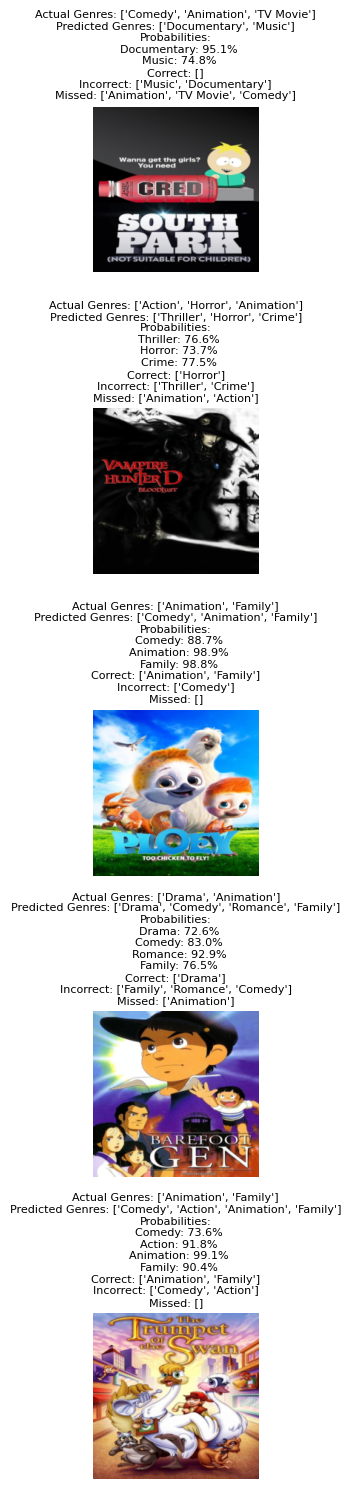

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Define the denormalize function
def denormalize(image_tensor):
    """
    Reverse normalization for visualization.
    Matches the mean and std used in val_transform.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert CHW to HWC
    image = std * image + mean  # Reverse normalization
    return np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1]

# Updated show_predictions function with probabilities
def show_predictions(model, dataloader, mlb, num_examples=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Display random predictions from the model after training with probabilities.

    Args:
        model: Trained PyTorch model
        dataloader: PyTorch DataLoader with test data
        mlb: MultiLabelBinarizer instance for genre labels
        num_examples: Number of examples to display (default: 5)
        device: Device to run the model on (default: CUDA if available, else CPU)
    """
    model.eval()  # Set model to evaluation mode

    # Convert dataloader to a list to allow random sampling
    all_batches = list(dataloader)
    if len(all_batches) == 0:
        print("Error: Dataloader is empty!")
        return

    # Randomly select a batch
    batch_idx = random.randint(0, len(all_batches) - 1)
    images, labels = all_batches[batch_idx]
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()  # Probability scores for each genre
        binary_preds = (probs > 0.7).astype(int)      # Binary predictions with threshold 0.7

    # Convert to CPU/numpy
    images = images.cpu()
    labels = labels.cpu().numpy()

    # Randomly select indices from the batch to display
    indices = random.sample(range(len(images)), min(num_examples, len(images)))

    # Plot
    plt.figure(figsize=(15, 3 * num_examples))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i + 1)
        image = denormalize(images[idx])  # Denormalize the image for display
        plt.imshow(image)

        # Get genres and probabilities
        true_genres = [mlb.classes_[j] for j in np.where(labels[idx] == 1)[0]]
        pred_genres = [mlb.classes_[j] for j in np.where(binary_preds[idx] == 1)[0]]
        pred_probs = {mlb.classes_[j]: f"{probs[idx, j] * 100:.1f}%" for j in range(len(mlb.classes_)) if binary_preds[idx, j] == 1}

        # Highlight correct and incorrect predictions
        correct_genres = set(true_genres) & set(pred_genres)
        incorrect_pred = set(pred_genres) - set(true_genres)
        missed_genres = set(true_genres) - set(pred_genres)

        # Build title with probabilities
        title = f"Actual Genres: {true_genres}\nPredicted Genres: {pred_genres}\n"
        title += "Probabilities:\n"
        for genre, prob in pred_probs.items():
            title += f"  {genre}: {prob}\n"
        title += f"Correct: {list(correct_genres)}\nIncorrect: {list(incorrect_pred)}\nMissed: {list(missed_genres)}"
        plt.title(title, fontsize=8)  # Reduced fontsize to fit more text
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prepare test dataset and loader
test_dataset = MoviePosterDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Show predictions after training with probabilities
print("Sample Predictions on Test Set (After Training) with Probabilities:")
show_predictions(model, test_loader, mlb, num_examples=5)